# Machine Learning - Lab Exam
## Daniele Orazi 
### daniele.orazi2@studio.unibo.it

In [159]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

1 Load the data, the attributes are all qualitative and there is no label column, show the shape of the data
and for each column show the frequencies of each distinct value (hint: you can use the numpy
function unique(x, return_counts = True)

In [160]:
data_url =  'exam_2021_02_17.csv'
sep = '\t'
df = pd.read_csv(data_url,sep=sep)

In [161]:
df.shape

(1000, 3)

In [162]:
np.unique(df['F0'], return_counts = True)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype=object),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

In [163]:
np.unique(df['F1'], return_counts = True)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype=object),
 array([100,  99, 100, 100, 101, 100, 100, 100, 100, 100]))

In [164]:
np.unique(df['F2'], return_counts = True)

(array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype=object),
 array([100,  99, 100, 100, 101, 100, 100, 100, 100, 100]))

2 Do the appropriate pre-processing in order to use the sklearn algorithms on this dataset; the values are
qualitative and must be considered as nominal

In [165]:
categorical_features=['F0','F1','F2']
transf_dtype = np.int64

categorical_transformer = OneHotEncoder(handle_unknown='ignore'
                                        , sparse = False
                                        , dtype = transf_dtype)
preprocessor = ColumnTransformer(
    transformers = [('cat', categorical_transformer, categorical_features)],
                    remainder = 'passthrough'
    )

In [166]:
preprocessor.fit(df)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(dtype=<class 'numpy.int64'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['F0', 'F1', 'F2'])])

In [167]:
print(preprocessor.named_transformers_)

{'cat': OneHotEncoder(dtype=<class 'numpy.int64'>, handle_unknown='ignore',
              sparse=False)}


In [168]:
df_p = preprocessor.fit_transform(df)

In [169]:
df_p.shape

(1000, 30)

In [170]:
df_p = pd.DataFrame(df_p)

3 As an external background knowledge, we are told that for this dataset a requirement for a good clustering
scheme is to have clusters with low deviation in sizes, e.g. a scheme with cluster sizes (330, 670) is less
acceptable than one with (333, 333, 334).
In order to obtain this, we want to compute, for each clustering scheme with n_clusters clusters and
represented by the labels in y, a size deviation index with the formula
np.sqrt(np.unique(y, return_counts = True)[1].var())/n_clusters
For varying number of clusters fit KMeans and compute the inertia, the silhouette index and the
above-mentioned size deviation index.

In [171]:
k_range = range(2,11)

In [172]:
distortions = []
silhouette_scores = []
size_deviation_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(df_p)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(df_p,y_km))
    size_deviation_scores.append(np.sqrt(np.unique(y_km, return_counts = True)[1].var())/i)

4 In this dataset the elbow method will show an almost “vanishing” elbow for inertia, and the silhouette is
totally non-effective. Make two plots, one with inertia and silhouette, another with inertia and size
deviation index, then decide the best number of clusters and refit KMeans using that value

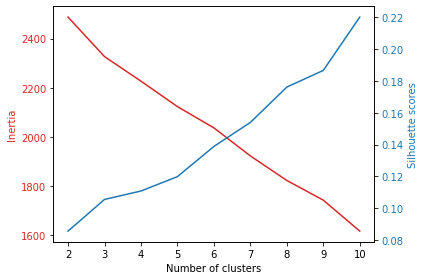

In [173]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

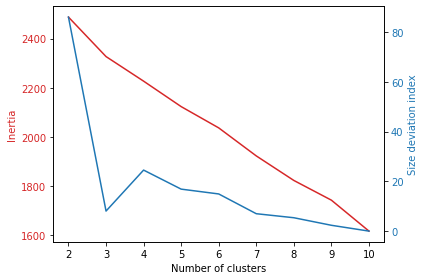

In [174]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Size deviation index', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, size_deviation_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Since the size deviation score seems to have a lower peack with k=3 I decide to use this value as the number of clusters.

In [175]:
good_k=3

In [176]:
km = KMeans(n_clusters=good_k, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)
y_km = km.fit_predict(df_p)

5 Fit another clustering method of your choice, trying to reproduce the same number of clusters you have
chosen in the previous step

In [177]:
X=df_p.to_numpy()

In [183]:
param_grid = {'eps': list(np.arange(1, 2, 0.1)),
              'min_samples': list(range(34,60,1))}
params = list(ParameterGrid(param_grid))
sil_thr = 0 
unc_thr = 50

In [179]:
silhouette_values = []
print("{:11}\t{:11}\t{:11}\t{:11}\t{:11},\t{:11}".\
      format('        eps','min_samples',' n_clusters',' silhouette', '    unclust%','    size deviation'))
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        silhouette_values.append(silhouette)
        size_deviation=np.sqrt(np.unique(y_db_cl, return_counts = True)[1].var())/n_clusters
        size_deviation_scores.append(size_deviation)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0])*100
        if silhouette > sil_thr and uncl_p < unc_thr:
            print("{:11.2f}\t{:11}\t{:11}\t{:11.2f}\t{:11.2f}%\t{:11.2f}"\
                  .format(db.eps, db.min_samples, n_clusters, silhouette, uncl_p, size_deviation))

        eps	min_samples	 n_clusters	 silhouette	    unclust%,	    size deviation
       1.50	         35	          2	       0.06	       0.00%	     101.50
       1.50	         36	          2	       0.06	       0.00%	     101.50
       1.50	         37	          2	       0.06	       0.10%	     101.25
       1.50	         38	          2	       0.06	       0.10%	     101.25
       1.50	         39	          3	       0.11	       0.50%	      10.36
       1.50	         40	          3	       0.11	       2.50%	      10.93
       1.50	         41	          3	       0.11	       4.10%	      13.08
       1.50	         42	          3	       0.11	       4.90%	      13.72
       1.50	         43	          3	       0.11	       6.60%	      14.43
       1.50	         44	          3	       0.11	       7.10%	      13.89
       1.50	         45	          3	       0.11	       8.10%	      14.30
       1.50	         46	          3	       0.12	       9.10%	      15.23
       1.50	         47	          3	       

In [180]:
db = DBSCAN(eps=1.5, min_samples=39)
y_db = db.fit_predict(df_p)
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

6 Compare the results of the two clustering showing the result
of sklearn.metrics.cluster.pair_confusion_matrix and sklearn.metrics.adjusted_rand_score

In [181]:
pair_confusion_matrix(y_km,y_db)

array([[659134,   5764],
       [  7934, 326168]])

In [182]:
adjusted_rand_score(y_km,y_db)

0.9691495998388563